<a href="https://colab.research.google.com/github/zaira-ra/ENSF444_Project/blob/main/ENSF444Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[Add some sort of introduction text]

In [ ]:
#pip install pandas numpy matplotlib seaborn scikit-learn jupyter


In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV


Load Data

In [ ]:
# Upload "Superstore.csv" in Google Colab using the file sidebar
# Or make sure it's in the working directory if using Jupyter Notebook
df = pd.read_csv("Superstore.csv", encoding='latin1')
df.head()# Show first few rows to confirm data loaded properly

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,6/12/2016,6/16/2016,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


Separate into feature matrix and target vector:

In [12]:
y = df['Profit']
X = df.drop(columns=['Profit'])

X['Order Date'] = pd.to_datetime(X['Order Date'])

# converting order date into year month day
X['Order Year'] = X['Order Date'].dt.year
X['Order Month'] = X['Order Date'].dt.month
X['Order Day'] = X['Order Date'].dt.day

# Drop original date columns and other non-predictive features
X = X.drop(columns=['Row ID', 'Order ID', 'Order Date', 'Ship Date',
                   'Customer ID', 'Customer Name', 'Country', 'Postal Code',
                   'Product ID', 'Product Name'])

print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Shape of X: (9994, 13)
Shape of y: (9994,)


Preprocessing:

In [13]:
#Check for missing values in X:
print("Missing values in X:\n", X.isnull().sum())
#There are no missing values

Missing values in X:
 Ship Mode       0
Segment         0
City            0
State           0
Region          0
Category        0
Sub-Category    0
Sales           0
Quantity        0
Discount        0
Order Year      0
Order Month     0
Order Day       0
dtype: int64


In [14]:
# Perform encoding on categorical values using pandas built-in encoding function
categorical_data = ['Ship Mode', 'Segment', 'City', 'State', 'Region',
                    'Category', 'Sub-Category']
X = pd.get_dummies(X, columns=categorical_data, drop_first=True)

numerical_cols = ['Sales', 'Quantity', 'Discount']

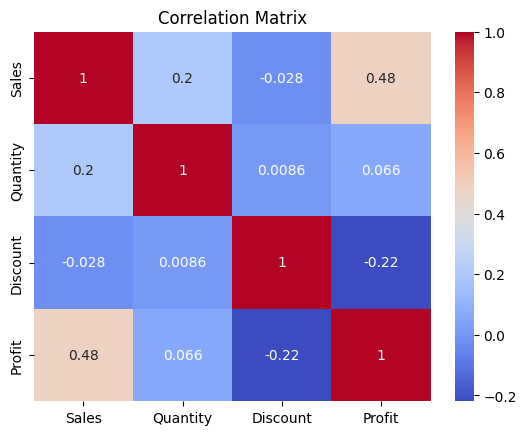

In [15]:
# Graphs to visualize data
plt.figure()
corr_matrix = df[['Sales', 'Quantity', 'Discount', 'Profit']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

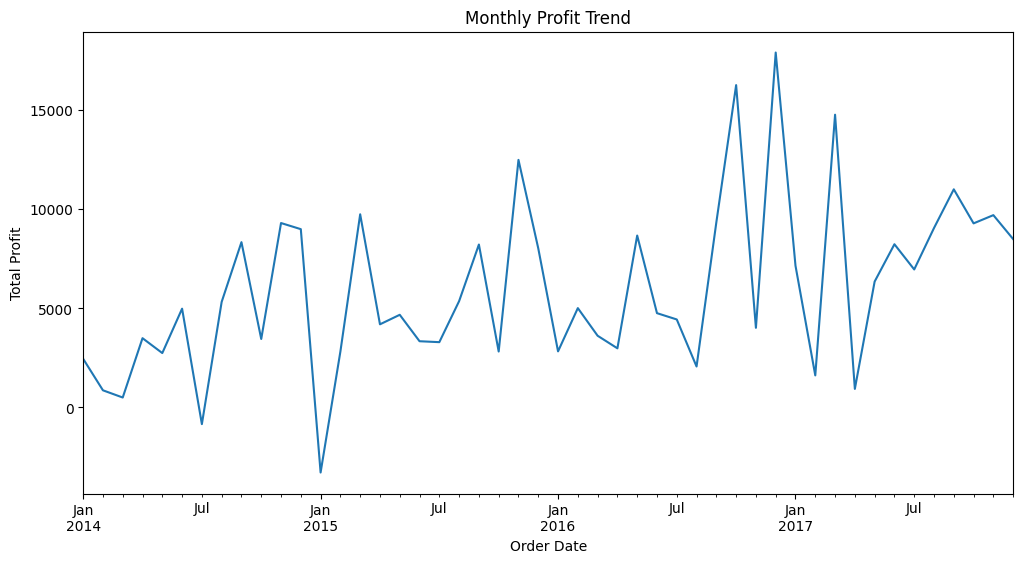

In [16]:
df['Order Date'] = pd.to_datetime(df['Order Date'])
monthly_profit = df.groupby(df['Order Date'].dt.to_period('M'))['Profit'].sum()
monthly_profit.plot(figsize=(12,6))
plt.title('Monthly Profit Trend')
plt.ylabel('Total Profit')
plt.show()

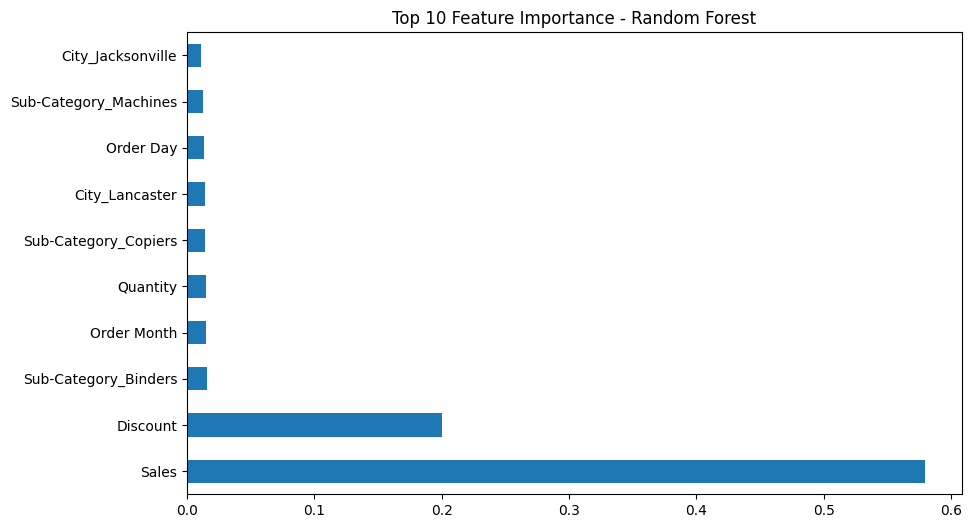

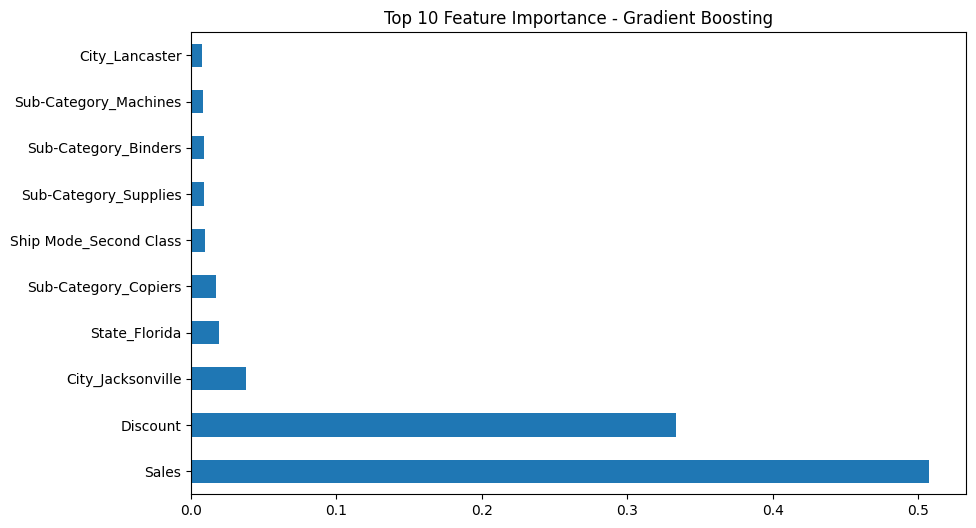

                         RMSE        R2  CV Mean R2
Linear Regression  230.910683  0.387676    0.204947
Random Forest      142.478003  0.766875    0.681991
Gradient Boosting  120.409796  0.833499    0.583018


In [17]:
# Implementing models

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Implementing scaling
scaler = StandardScaler()
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=0),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=0)
}

# Train and evaluate models
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')

    results[name] = {
        'RMSE': rmse,
        'R2': r2,
        'CV Mean R2': np.mean(cv_scores)
    }

    # Feature importance for tree-based models
    if hasattr(model, 'feature_importances_'):
        importances = pd.Series(model.feature_importances_, index=X.columns)
        plt.figure(figsize=(10,6))
        importances.nlargest(10).plot(kind='barh')
        plt.title(f'Top 10 Feature Importance - {name}')
        plt.show()

# Compare model performance
results_df = pd.DataFrame(results).T
print(results_df)

In [25]:
#Hyperparameter Tuning (For Best Performing Model)


# Define parameter grids for all models
param_grids = {
    'Linear Regression': {},
    'Random Forest': {
        'n_estimators': [100], #changed from 100, 200 to just 100 because of amount and time
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    },
    'Gradient Boosting': {
        'n_estimators': [50, 100],
        'max_depth': [3, 5, 7]
    }
}

# Initialize models with their parameter grids
models = {
    'Linear Regression': {
        'model': LinearRegression(),
        'params': param_grids['Linear Regression']
    },
    'Random Forest': {
        'model': RandomForestRegressor(random_state=0),
        'params': param_grids['Random Forest']
    },
    'Gradient Boosting': {
        'model': GradientBoostingRegressor(random_state=0),
        'params': param_grids['Gradient Boosting']
    }
}

# Train and evaluate models with GridSearchCV
results = {}
best_models = {}

for name, model_info in models.items():
    print(f"\nPerforming grid search for {name}...")

    grid_search = GridSearchCV(
        estimator=model_info['model'],
        param_grid=model_info['params'],
        cv=3,
        scoring='r2',
        n_jobs=-1,
        verbose=1
    )

    grid_search.fit(X_train, y_train) #takes 7 minutes to run

    # Store best model
    best_models[name] = grid_search.best_estimator_

    # Evaluate on test set
    y_pred = grid_search.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    results[name] = {
        'Best Parameters': grid_search.best_params_,
        'R2': r2,
        'Cross Validation Train Score': grid_search.best_score_
    }


# Compare model performance
results_df = pd.DataFrame(results).T
print("\nModel Comparison:")
print(results_df)


Performing grid search for Linear Regression...
Fitting 3 folds for each of 1 candidates, totalling 3 fits

Performing grid search for Random Forest...
Fitting 3 folds for each of 12 candidates, totalling 36 fits

Performing grid search for Gradient Boosting...
Fitting 3 folds for each of 6 candidates, totalling 18 fits

Model Comparison:
                                                     Best Parameters  \
Linear Regression                                                 {}   
Random Forest      {'max_depth': 20, 'min_samples_leaf': 1, 'min_...   
Gradient Boosting              {'max_depth': 5, 'n_estimators': 100}   

                         R2 Cross Validation Train Score  
Linear Regression  0.387676                     0.211752  
Random Forest      0.755738                     0.648254  
Gradient Boosting   0.85335                     0.709766  


In [27]:
cv_results = grid_search.cv_results_
best_index = grid_search.best_index_
print(f"Best cross-validation test score: {cv_results['mean_test_score'][best_index]}")

print(f"Test-set score, accuracy: {grid_search.score(X_test, y_test)}")
#these scores are Gradient Boosting's scores

Best cross-validation test score: 0.70976626406959
Test-set score, accuracy: 0.8533502241220459


Gradient Boosting had the best scores

In [ ]:
# For Colab: upload the CSV from sidebar first, then run cells sequentially
# For Jupyter: ensure the CSV is in the same directory as the notebook